# Spotter Benchmark Analysis

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from experiments.collaborative.analysis import (
    load_dataset,
    get_gold_answer_dataset,
    MODEL_DISPLAY_NAMES,
    get_spotter_type_short,
)

In [32]:
%config InlineBackend.figure_format = 'retina'

# set seaborn color palette
sns.set_palette("Set2")

# set seaborn style
sns.set_style("white")
sns.set_context("talk")

In [33]:
EXPERIMENT_NAME = "battleship-final-data"
PATH_DATA = os.path.join("data", EXPERIMENT_NAME)
PATH_EXPORT = os.path.join(PATH_DATA, "export")

df_gold = load_dataset(experiment_path=PATH_DATA, use_gold=True)

                        gameID       ended  timeoutGameEnd  gameCompleted
22  01JJ2SEBPTDG0QW8S395B2NSB8  game ended            True          False
These will be kept in the dataset.


In [34]:
RESULTS_PATH = os.path.join(
    "spotter_benchmarks", "run_2025_07_09_16_55_45", "summary.json"
)

df = pd.read_json(RESULTS_PATH)
df

,llm,use_cot,spotter_type,round_id,question_id,question,program,occ_tiles,answer_text,answer_value,...,gold_answer_text,gold_answer_value,is_correct,spotter_json,gold_answer,gold_discourse,gold_stateful,gold_vague,gold_ambiguous,gold_unanswerable
0,openai/o4-mini,False,DirectSpotterModel,01JDMZVSGBA3PJBC5AY3SB613R,1,is there a ship longer than 3 tiles,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False
1,openai/o4-mini,False,DirectSpotterModel,01JDMZWAWZ285CAQTCRXPHG1FQ,1,Are there any ships within E-H?,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False
2,openai/o4-mini,False,DirectSpotterModel,01JDN0GYZPS3DEFJRWYAE14GQM,1,is there a ship between E1 to E8,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False
3,openai/o4-mini,True,DirectSpotterModel,01JDMZVSGBA3PJBC5AY3SB613R,1,is there a ship longer than 3 tiles,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False
4,openai/o4-mini,True,DirectSpotterModel,01JDMZWAWZ285CAQTCRXPHG1FQ,1,Are there any ships within E-H?,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,deepseek/deepseek-r1-0528,False,CodeSpotterModel,01JDMZWAWZ285CAQTCRXPHG1FQ,1,Are there any ships within E-H?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False
68,deepseek/deepseek-r1-0528,False,CodeSpotterModel,01JDN0GYZPS3DEFJRWYAE14GQM,1,is there a ship between E1 to E8,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False
69,deepseek/deepseek-r1-0528,True,CodeSpotterModel,01JDMZVSGBA3PJBC5AY3SB613R,1,is there a ship longer than 3 tiles,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False
70,deepseek/deepseek-r1-0528,True,CodeSpotterModel,01JDMZWAWZ285CAQTCRXPHG1FQ,1,Are there any ships within E-H?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,yes,True,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False


In [35]:
# Add display names and categorizations for analysis
def add_display_fields(df):
    """Add display names and categorizations to the dataframe."""
    # Add spotter type categorization
    df["spotter_type_short"] = df.apply(
        lambda row: get_spotter_type_short(row["spotter_type"], row["use_cot"]), axis=1
    )

    # Add model display name
    df["llm_display_name"] = df["llm"].map(MODEL_DISPLAY_NAMES)

    return df

# Process the dataframe
df = add_display_fields(df)
df


,llm,use_cot,spotter_type,round_id,question_id,question,program,occ_tiles,answer_text,answer_value,...,is_correct,spotter_json,gold_answer,gold_discourse,gold_stateful,gold_vague,gold_ambiguous,gold_unanswerable,spotter_type_short,llm_display_name
0,openai/o4-mini,False,DirectSpotterModel,01JDMZVSGBA3PJBC5AY3SB613R,1,is there a ship longer than 3 tiles,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,Base,o4-mini
1,openai/o4-mini,False,DirectSpotterModel,01JDMZWAWZ285CAQTCRXPHG1FQ,1,Are there any ships within E-H?,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,Base,o4-mini
2,openai/o4-mini,False,DirectSpotterModel,01JDN0GYZPS3DEFJRWYAE14GQM,1,is there a ship between E1 to E8,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,Base,o4-mini
3,openai/o4-mini,True,DirectSpotterModel,01JDMZVSGBA3PJBC5AY3SB613R,1,is there a ship longer than 3 tiles,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,+ CoT,o4-mini
4,openai/o4-mini,True,DirectSpotterModel,01JDMZWAWZ285CAQTCRXPHG1FQ,1,Are there any ships within E-H?,None,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,+ CoT,o4-mini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,deepseek/deepseek-r1-0528,False,CodeSpotterModel,01JDMZWAWZ285CAQTCRXPHG1FQ,1,Are there any ships within E-H?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,+ Code,deepseek-r1
68,deepseek/deepseek-r1-0528,False,CodeSpotterModel,01JDN0GYZPS3DEFJRWYAE14GQM,1,is there a ship between E1 to E8,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,+ Code,deepseek-r1
69,deepseek/deepseek-r1-0528,True,CodeSpotterModel,01JDMZVSGBA3PJBC5AY3SB613R,1,is there a ship longer than 3 tiles,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,+ CoT + Code,deepseek-r1
70,deepseek/deepseek-r1-0528,True,CodeSpotterModel,01JDMZWAWZ285CAQTCRXPHG1FQ,1,Are there any ships within E-H?,\nimport numpy as np\n\ndef answer(true_board:...,"[[-1,-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,...",yes,True,...,True,experiments/collaborative/spotter_benchmarks/r...,yes,False,False,False,False,False,+ CoT + Code,deepseek-r1


<Axes: xlabel='answer_text'>

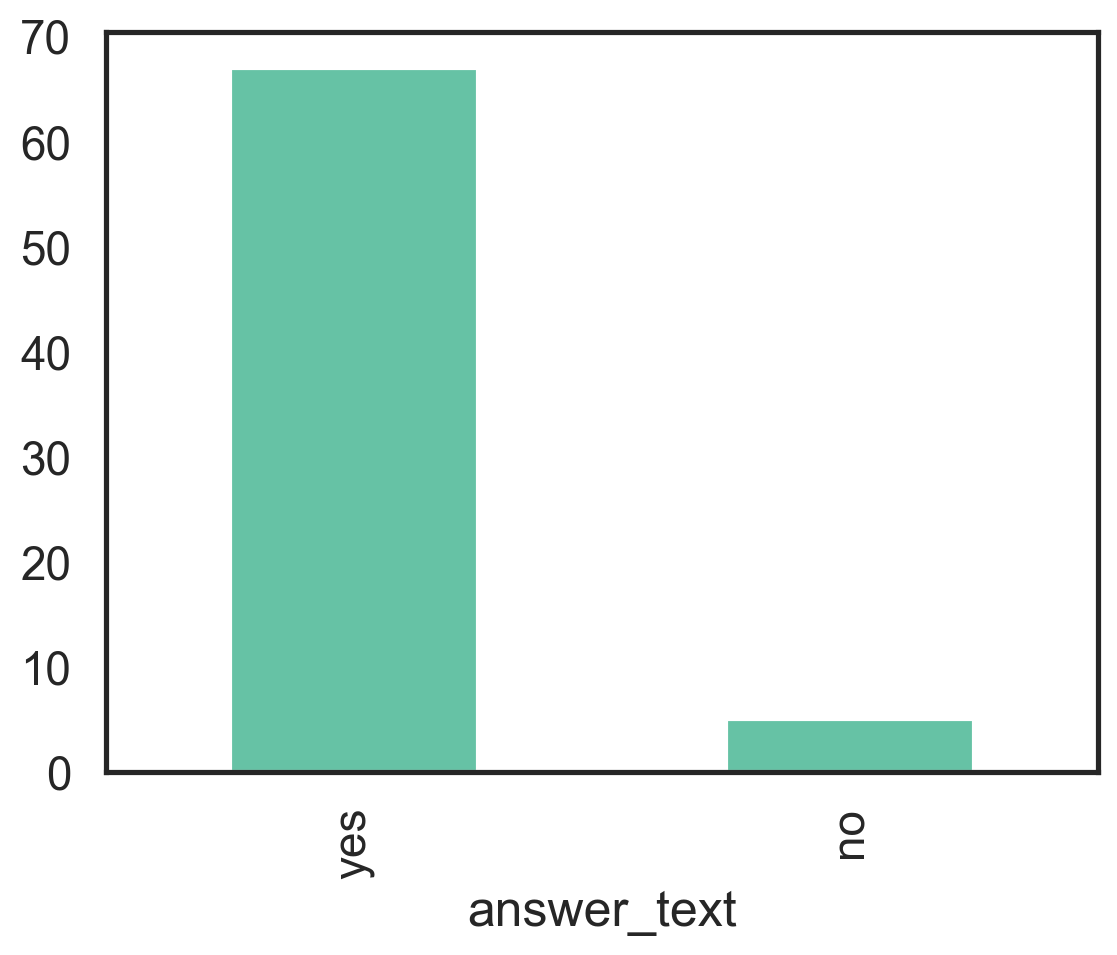

In [36]:
# Check distribution of raw answer text
df["answer_text"].value_counts(dropna=False).plot(kind="bar")

In [37]:
gold_labels, human_labels = get_gold_answer_dataset(df_gold)
print(len(gold_labels), len(human_labels))

931 931


In [38]:
print(classification_report(y_true=gold_labels, y_pred=human_labels))

human_accuracy_baseline = classification_report(y_true=gold_labels, y_pred=human_labels, output_dict=True)["accuracy"]
print(f"Human accuracy baseline: {human_accuracy_baseline:.2%}")

              precision    recall  f1-score   support

       False       0.92      0.91      0.92       421
        True       0.93      0.94      0.93       510

    accuracy                           0.92       931
   macro avg       0.92      0.92      0.92       931
weighted avg       0.92      0.92      0.92       931

Human accuracy baseline: 92.48%


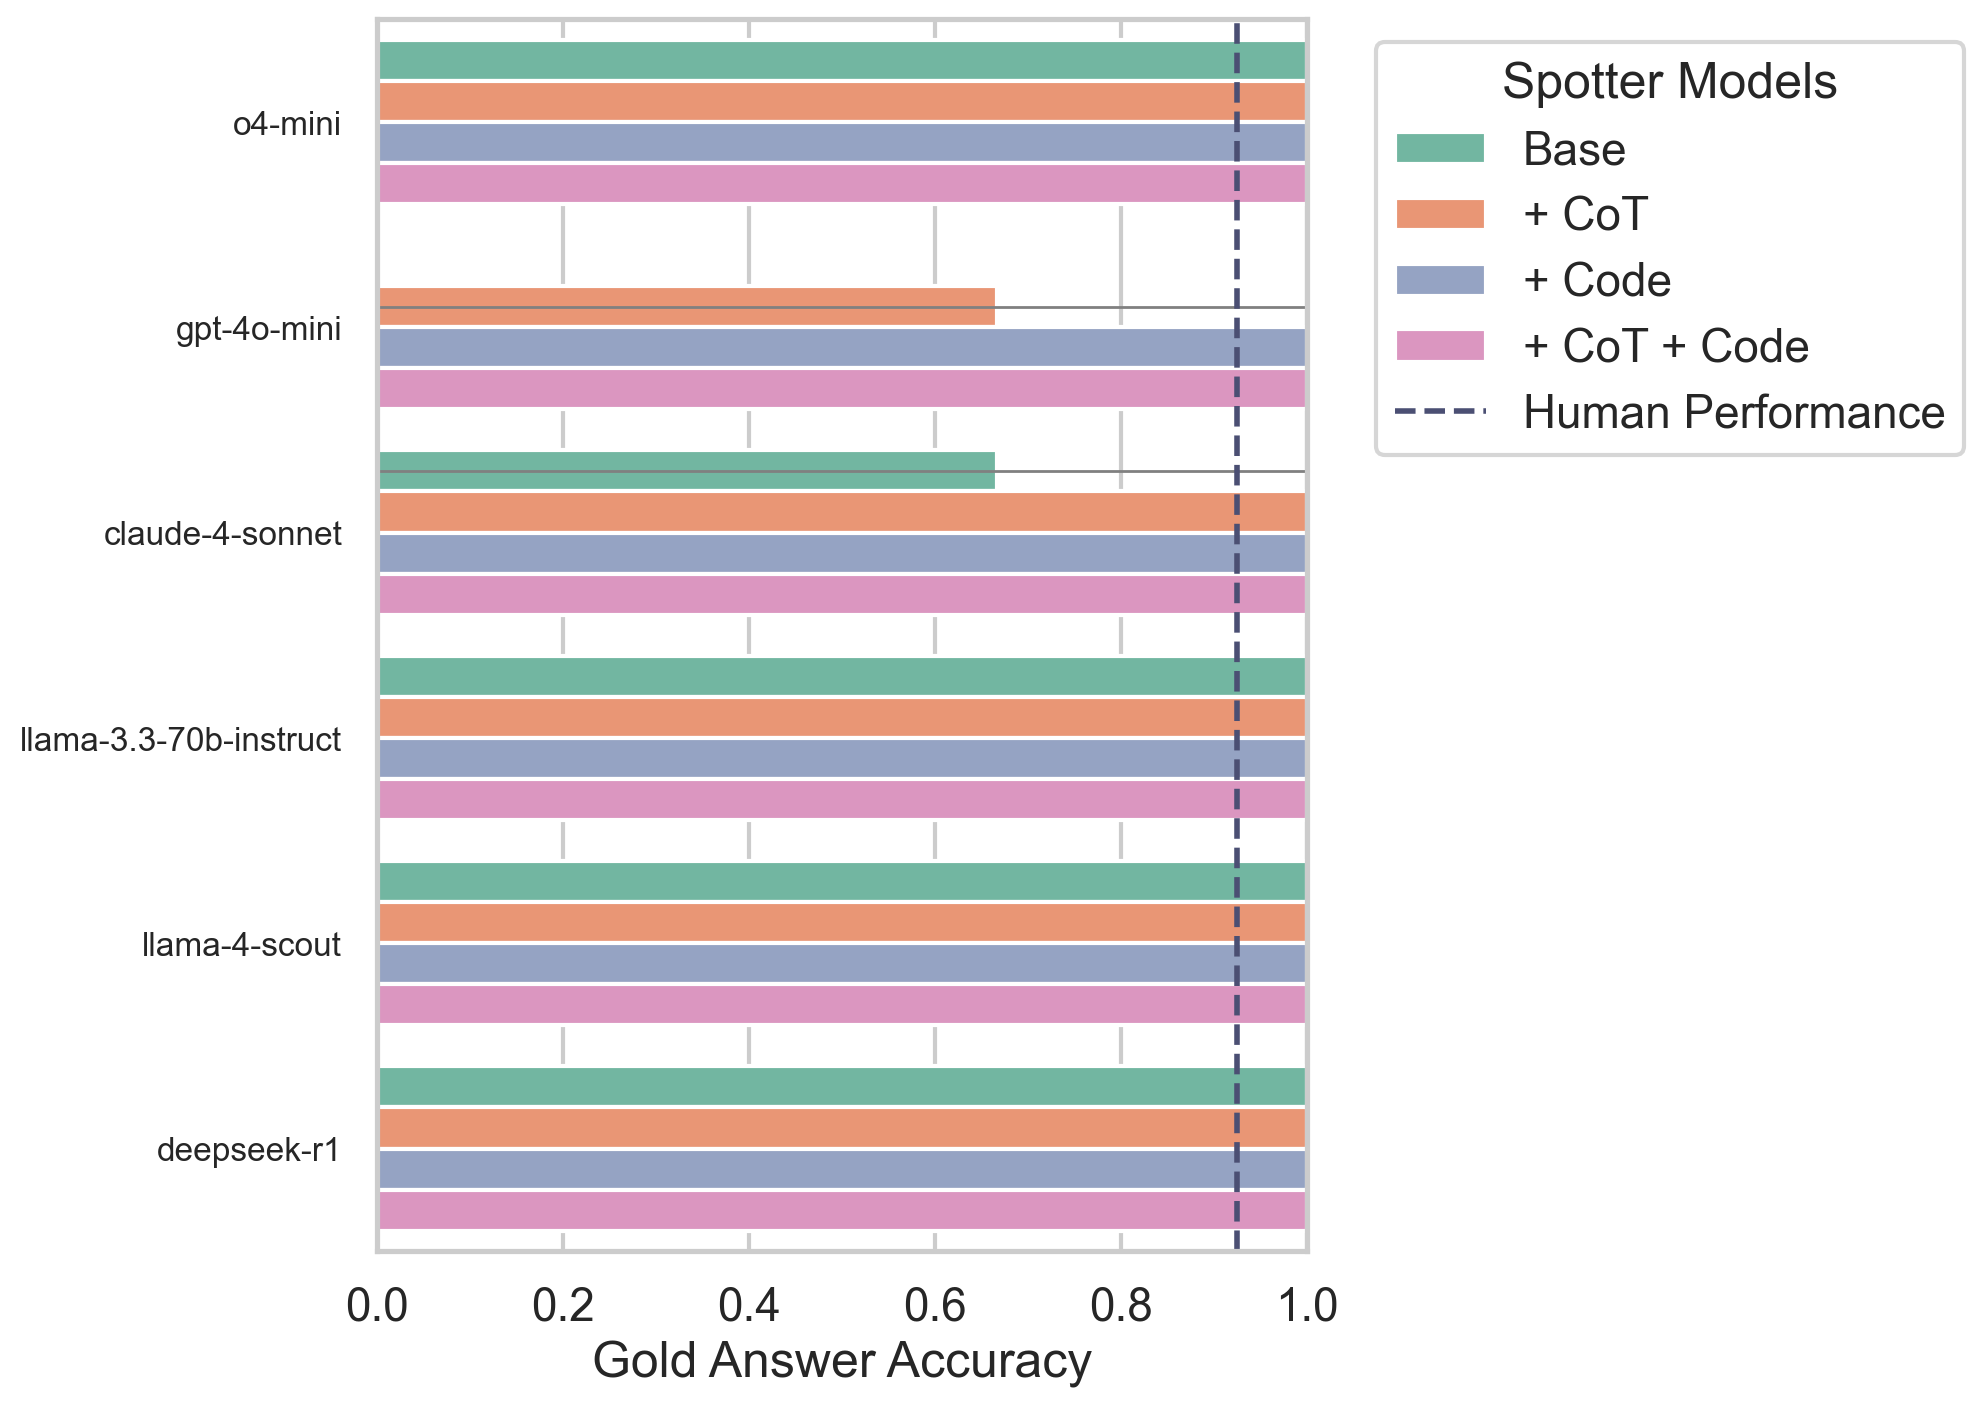

In [39]:
with sns.plotting_context(context="talk"), sns.axes_style("whitegrid"):

    plt.figure(figsize=(6, 8))
    sns.barplot(
        data=df,
        x="is_correct",
        y="llm_display_name",
        hue="spotter_type_short",
        errorbar=("ci", 95),
        err_kws={
            "color": "gray",
            "linewidth": 1,
        },
        capsize=0.2,
    )

    plt.axvline(
        human_accuracy_baseline,
        color="#4b4f73",
        linestyle="--",
        linewidth=2.0,
        label="Human Performance",
    )

    plt.ylabel("")
    plt.xlabel("Gold Answer Accuracy")

    plt.xlim(0.0, 1.0)

    plt.yticks(fontsize=12)

    plt.legend(title="Spotter Models", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.savefig(
        os.path.join(PATH_EXPORT, "spotter_accuracy.pdf"),
        bbox_inches="tight",
        dpi=300,
    )